In [ ]:
from keras import backend as K
import numpy as np
from keras.models import Model
import matplotlib
import matplotlib.pyplot as plt
from vgg16_avg import Vgg16_avg
from scipy.misc import imread, imresize

%matplotlib inline
%load_ext autoreload
%autoreload 2

Using TensorFlow backend.


###### Preprocessing
The input images should be zero-centered by mean pixel (rather than mean image) subtraction. Namely, the following BGR values should be subtracted: [103.939, 116.779, 123.68].

In [ ]:
def load_image(filename, scale_factor=None):
    img = imread(filename)
    if scale_factor is not None:
        return imresize(img, scale_factor)
    return img

def preprocess_image(img):
    '''
    Zero mean to the image file.
    Inputs:
    - img: numpy array of the image.
    Returns:
    - numpy array of the image
    '''
    img = img.astype(np.float32)
    img = img[..., ::-1] # RGB -> BGR
    img[..., 0] -= 103.939
    img[..., 1] -= 116.779
    img[..., 2] -= 123.68
    return img

def deprocess_image(img):
    '''
    Inputs:
    - img: numpy array of the image file
    Returns:
    - numpy array of the same image
    '''
    img[..., 0] += 103.939
    img[..., 1] += 116.779
    img[..., 2] += 123.68
    img = img[..., ::-1] # BGR -> RGB
    img = np.clip(img, 0, 255).astype(np.uint8)
    return img

Peek the starry night

In [ ]:
style_image = 'styles/starry_night.jpg'

scale_factor = .2

img = preprocess_image(load_image(style_image, scale_factor))
img = np.expand_dims(img, 0)
plt.imshow(deprocess_image(img[0]))

###### Load the vgg16 model and weights
Vgg16_avg.extract_features extracts the output of each convlutional layers. Keras' [FAQ](https://keras.io/getting-started/faq/#how-can-i-obtain-the-output-of-an-intermediate-layer) detailed how to do this. Tensorflow can do this more easily, though.

In [ ]:
vgg16 = Vgg16_avg(include_top=False)

## Computing Loss

We're going to compute the three components of our loss function now. The loss function is a weighted sum of three terms: content loss + style loss + total variation loss.

![Loss](StyleTransfer_Loss.jpg)

## Content loss
We can generate an image that reflects the content of one image and the style of another by incorporating both in our loss function. We want to penalize deviations from the content of the content image and deviations from the style of the style image. We can then use this hybrid loss function to perform gradient descent **not on the parameters** of the model, but instead **on the pixel values** of our original image.

Let's first write the content loss function. Content loss measures how much the feature map of the generated image differs from the feature map of the source image. We only care about the content representation of one layer of the network (say, layer $\ell$), that has feature maps $A^\ell \in \mathbb{R}^{1 \times C_\ell \times H_\ell \times W_\ell}$. $C_\ell$ is the number of filters/channels in layer $\ell$, $H_\ell$ and $W_\ell$ are the height and width. We will work with reshaped versions of these feature maps that combine all spatial positions into one dimension. Let $F^\ell \in \mathbb{R}^{N_\ell \times M_\ell}$ be the feature map for the current image and $P^\ell \in \mathbb{R}^{N_\ell \times M_\ell}$ be the feature map for the content source image where $M_\ell=H_\ell\times W_\ell$ is the number of elements in each feature map. Each row of $F^\ell$ or $P^\ell$ represents the vectorized activations of a particular filter, convolved over all positions of the image. Finally, let $w_c$ be the weight of the content loss term in the loss function.

Then the content loss is given by:

$L_c = w_c \times \sum_{i,j} (F_{ij}^{\ell} - P_{ij}^{\ell})^2$

In [ ]:
def content_loss(content_weight, content_current, content_original):
    '''
    content_current: the generated output from a random image.
    content_original: the generated output from the original image.
    
    Return: a scalar loss masures how different are the two images.
    '''
    return content_weight * K.sum(K.square(content_current - content_original))

## Style loss
Now we can tackle the style loss. For a given layer $\ell$, the style loss is defined as follows:

First, compute the Gram matrix G which represents the correlations between the responses of each filter, where F is as above. The Gram matrix is an approximation to the covariance matrix -- we want the activation statistics of our generated image to match the activation statistics of our style image, and matching the (approximate) covariance is one way to do that. There are a variety of ways you could do this, but the Gram matrix is nice because it's easy to compute and in practice shows good results.

Given a feature map $F^\ell$ of shape $(1, C_\ell, M_\ell)$, the Gram matrix has shape $(1, C_\ell, C_\ell)$ and its elements are given by:

$$G_{ij}^\ell  = \sum_k F^{\ell}_{ik} F^{\ell}_{jk}$$

Assuming $G^\ell$ is the Gram matrix from the feature map of the current image, $A^\ell$ is the Gram Matrix from the feature map of the source style image, and $w_\ell$ a scalar weight term, then the style loss for the layer $\ell$ is simply the weighted Euclidean distance between the two Gram matrices:

$$L_s^\ell = w_\ell \sum_{i, j} \left(G^\ell_{ij} - A^\ell_{ij}\right)^2$$

In practice we usually compute the style loss at a set of layers $\mathcal{L}$ rather than just a single layer $\ell$; then the total style loss is the sum of style losses at each layer:

$$L_s = \sum_{\ell \in \mathcal{L}} L_s^\ell$$

In [ ]:
def gram_matrix(features, normalize=True):
    """
    Compute the Gram matrix from features.
    
    Inputs:
    - features: Tensor of shape (1, H, W, C) giving features for
      a single image.
    - normalize: optional, whether to normalize the Gram matrix
        If True, divide the Gram matrix by the number of neurons (H * W * C)
    
    Returns:
    - gram: Tensor of shape (C, C) giving the (optionally normalized)
      Gram matrices for the input image.
    """
    s = K.shape(features)
    f = K.reshape(features, shape=(s[1], s[2], s[3]))
    f = K.permute_dimensions(f, (2, 0, 1))
    f = K.reshape(f, shape=(s[3], -1))
    gram = K.dot(f, K.transpose(f))
    if normalize:
        gram /= K.cast(s[1] * s[2] * s[3], K.floatx())
    return gram

In [ ]:
def style_loss(feats, style_layers, style_targets, style_weights):
    """
    Computes the style loss at a set of layers.
    
    Inputs:
    - feats: list of the features at every layer of the current image, as produced by
      the extract_features function.
    - style_layers: List of layer indices into feats giving the layers to include in the
      style loss.
    - style_targets: List of the same length as style_layers, where style_targets[i] is
      a Tensor giving the Gram matrix the source style image computed at
      layer style_layers[i].
    - style_weights: List of the same length as style_layers, where style_weights[i]
      is a scalar giving the weight for the style loss at layer style_layers[i].
      
    Returns:
    - style_loss: A Tensor contataining the scalar style loss.
    """
    loss = 0
    for i, n in enumerate(style_layers):
        loss += style_weights[i] * K.sum(K.square(gram_matrix(feats[n]) - style_targets[i]))
    return loss

## Total-variation regularization
It turns out that it's helpful to also encourage smoothness in the image. We can do this by adding another term to our loss that penalizes wiggles or "total variation" in the pixel values. 

You can compute the "total variation" as the sum of the squares of differences in the pixel values for all pairs of pixels that are next to each other (horizontally or vertically). Here we sum the total-variation regualarization for each of the 3 input channels (RGB), and weight the total summed loss by the total variation weight, $w_t$:

$L_{tv} = w_t \times \sum_{c=1}^3\sum_{i=1}^{H-1} \sum_{j=1}^{W-1} \left( (x_{i,j+1, c} - x_{i,j,c})^2 + (x_{i+1, j,c} - x_{i,j,c})^2  \right)$

In [ ]:
def tv_loss(img, tv_weight):
    """
    Compute total variation loss.
    
    Inputs:
    - img: Tensor of shape (1, H, W, 3) holding an input image.
    - tv_weight: Scalar giving the weight w_t to use for the TV loss.
    
    Returns:
    - loss: Tensor holding a scalar giving the total variation loss
      for img weighted by tv_weight.
    """
    # Your implementation should be vectorized and not require any loops!
    # pass
    h = K.square(img[:, :-1, :-1] - img[:, 1:, :-1])
    w = K.square(img[:, :-1, :-1] - img[:, :-1, 1:])
    return tv_weight * K.sum(h + w)

# Style Transfer

Use Evaluator to compute both the loss and gradidents

In [9]:
class Evaluator(object):
    def __init__(self, f, shp):
        self.f = f
        self.shp = shp
        self.loss_value = None
        self.grads_values = None
        
    def loss(self, x):
        x = x.reshape(self.shp)
        self.loss_value, self.grads_values = self.f([x])
        return self.loss_value.astype(np.float64)
    
    def grads(self, x):
        return self.grads_values.flatten().astype(np.float64)

Use [fmin_l_bfgs_b](https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.optimize.fmin_l_bfgs_b.html) to optimize the loss wrt input.

In [ ]:
def style_transfer(model, content_image, style_image, image_size, style_size, content_layer, content_weight,
                   style_layers, style_weights, tv_weight, init_random = False):
    """Run style transfer!
    
    Inputs:
    - content_image: filename of content image
    - style_image: filename of style image
    - image_size: size of smallest image dimension (used for content loss and generated image)
    - style_size: size of smallest style image dimension
    - content_layer: layer to use for content loss
    - content_weight: weighting on content loss
    - style_layers: list of layers to use for style loss
    - style_weights: list of weights to use for each layer in style_layers
    - tv_weight: weight of total variation regularization term
    - init_random: initialize the starting image to uniform random noise
    """
    # Extract features from the content image
    content_img = preprocess_image(load_image(content_image, 0.2))
    content_img = np.expand_dims(content_img, axis=0)
    feats = model.extract_features()
    content_target = K.function([model.input], [feats[content_layer]])([content_img])[0]
    
    # Extract features from the style image
    style_img = preprocess_image(load_image(style_image, 0.2))
    style_img = np.expand_dims(style_img, axis=0)
    style_feat_vars = [feats[idx] for idx in style_layers]
    style_target_vars = []
    for style_feat_var in style_feat_vars:
        style_target_vars.append(gram_matrix(style_feat_var))
    style_targets = K.function([model.input], style_target_vars)([style_img])
    
    # Initialize generated image to content image
    if init_random:
        x = np.random.uniform(-2.5, 2.5, content_img.shape).astype(np.float32) / 100
    else:
        x = content_img.copy()
        
    # Compute loss
    c_loss = content_loss(content_weight, feats[content_layer], content_target)
    s_loss = style_loss(feats, style_layers, style_targets, style_weights)
    t_loss = tv_loss(x, tv_weight)
    loss = c_loss + s_loss + t_loss

    grads = K.gradients(loss, model.input)

    fn = K.function([model.input], [loss] + grads)
    evaluator = Evaluator(fn, x.shape)
    
    f, axarr = plt.subplots(1,2)
    axarr[0].axis('off')
    axarr[1].axis('off')
    axarr[0].set_title('Content Source Img.')
    axarr[1].set_title('Style Source Img.')
    axarr[0].imshow(deprocess_image(content_img[0]))
    axarr[1].imshow(deprocess_image(style_img[0]))
    plt.show()
    plt.figure()
    
    from scipy.optimize import fmin_l_bfgs_b
    
    niter = 5
    for i in range(niter):
        x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x.flatten(),
                                        fprime=evaluator.grads, maxfun=20)
        x = np.clip(x, -127, 127)
        print('Iteration {} - Loss = {}'.format(i + 1, min_val))
        plt.imshow(deprocess_image(x.copy().reshape(content_img.shape)[0]))
        plt.axis('off')
        plt.show()
        
    plt.imshow(deprocess_image(x.reshape(content_img.shape)[0]))   

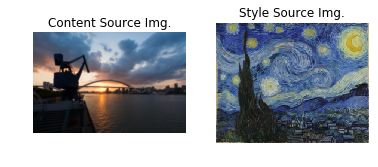

Iteration 1 - Loss = 9812900.0


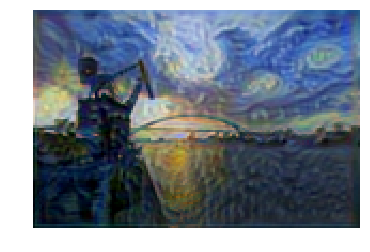

Iteration 2 - Loss = 6066929.5


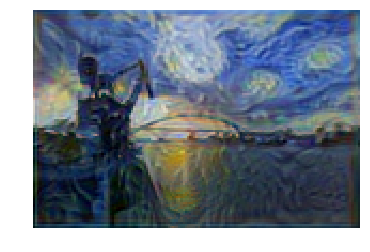

Iteration 3 - Loss = 5328940.5


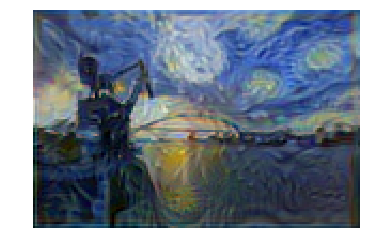

Iteration 4 - Loss = 4971433.0


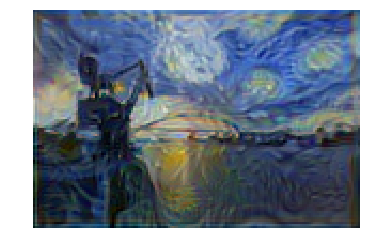

Iteration 5 - Loss = 4793206.0


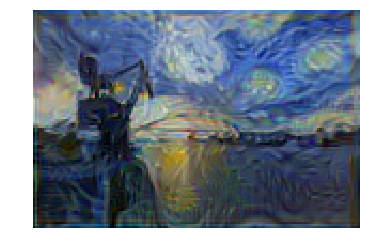

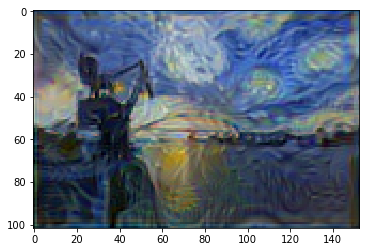

In [13]:
# Composition VII + Tubingen
params1 = {
    'content_image' : 'styles/_DSC7144.jpg',
    'style_image' : 'styles/starry_night.jpg',
    'image_size' : 192,
    'style_size' : 512,
    'content_layer' : 9,
    'content_weight' : 5e-2, 
    'style_layers' : (1, 3, 6, 9, 12),
    'style_weights' : (0.05, 0.2,0.2,0.25,0.3),
    'tv_weight' : 5e-2
}

style_transfer(vgg16, **params1)